# Model-based Collaborative filtering with GA4 Dallas Free Press dataset

* Dataset: GA4 DFP
* CF-type: Model
* Implicit/Explicit: Implicit
* User-User/Item-Item: Does not apply

## Approach

In this notebook, we're going to build up a model-based collaborative filter using matrix factorization. It is possible to employ other model-based methods, by refomatting the problem as a supervised learning task using XGBoost/decisions trees/etc, however this is not traditional. We may incorperate additional model strategies as we seek to incorperate more data into our predictions. 

Our primary goal here is to build up a process for making predictions. The specifics for how  

Once these are established, we'll start incorporating multiple sources of feedback ... using feature aware matrix factorization. More details [here](https://docs.google.com/document/d/1mO94wAjdVFDRKSQo7JYVkd_NsiBDkHxhfyj7u_uZY9Q/edit?tab=t.0#heading=h.yevokmfzxk7). 

# Step 1: Preprocess user-article interaction matrix

We have the option of using any one of the user-article interaction matrices that we [created to power our memory-based collaborative filters](./cf-ga4-dfp-memory.ipynb). For now, lets use the following matrix with the acknowledgement that we could swap it out:
* Whether the user Scrolled n-amount of the article page


In [ ]:
import glob
import os
import json
from urllib.parse import urljoin, urlparse

import pandas as pd


# Define the path to the folder containing the GA4 event files
folder_path = "../data/ga4-dfp/raw/"

# Use glob to get all .json files in the folder
file_paths = glob.glob(os.path.join(folder_path, "*.json"))

###################
# Matrix: page scroll depth
###################
scroll_depth_records = []
for file_path in file_paths:
    with open(file_path) as f:
        data = json.load(f)

    for event in data:
        if event.get("event_name") == "scroll_custom":
            user_id = event.get("user_pseudo_id")
            # Cast event_params to a dictionary for easier access to page location and scroll depth
            params = {p["key"]: p["value"] for p in event.get("event_params", [])}

            # Extract page_location and perform a little url cleanup
            page_location = params.get("page_location", {}).get("string_value")
            page_location = urljoin(page_location, urlparse(page_location).path)
            # Extract percent_scrolled
            percent_scrolled = params.get("percent_scrolled", {}).get("int_value")

            if user_id and page_location and percent_scrolled is not None:
                scroll_depth_records.append(
                    {
                        "user_pseudo_id": user_id,
                        "page_location": page_location,
                        "percent_scrolled": int(percent_scrolled),
                    }
                )


# Convert to DataFrame and find max scroll per user per page
user_page_scroll_matrix = pd.DataFrame(scroll_depth_records)
user_page_scroll_matrix = user_page_scroll_matrix.pivot_table(
    index="user_pseudo_id",
    columns="page_location",
    values="percent_scrolled",
    aggfunc="max",
    fill_value=0,
)

print(user_page_scroll_matrix.head())

page_location          https://dallasfreepdev.wpengine.com/  \
user_pseudo_id                                                
1000102388.1739115104                                     0   
1000496648.1739037737                                     0   
1001135239.1739063145                                     0   
1002132338.1739895220                                     0   
1002238659.1738966000                                     0   

page_location          https://dallasfreepress-com.translate.goog/es/south-dallas/los-estudiantes-regresan-a-la-escuela-virtual-pero-las-familias-de-dallas-no-tienen-acceso-al-internet/  \
user_pseudo_id                                                                                                                                                                              
1000102388.1739115104                                                  0                                                                                                            

# Step 2: Define model-training process

There are many ways to build a model, making it difficult to fully optimize within this Jupyter Notebook context.

Te best we can do right now is commit to an implementation and record the specific design decisions we are making such that we can replicate them at the production level. 


## Model training steps

1. Create sparse interaction matrix to more optimally store user-item interaction matrix
2. Split sparse interaction matrix into training and test data
3. Perform several matrix factorization experiements (SVD + dot product) over training data.
    a. For each experiement, select a number of latent features to use
    b. Calculate the RMSE, Precision@K, Recall@K and NDCG@K score of each experiement by comparing dot product with test data
4. Plot scores and latent features. Watch for when graph "elbows" (point where marginal decrease in score from extra features tails off) to select optimial model with the optimal number of features.
5. Evaluate the recommendation quality of the optimal model

In [ ]:
from scipy.sparse import csr_matrix


def to_sparse_matrix(df):
    """Convert a dense DataFrame into a sparse matrix format."""
    return csr_matrix(df.values)

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split


def train_test_split_mask(matrix, test_fraction=0.2, random_state=42):
    """
    For each user, hold out a fraction of interactions for evaluation.

    Parameters:
    - matrix: numpy array, user-item interaction matrix
    - test_fraction: float, fraction of interactions to hold out per user
    - random_state: int, seed for reproducibility

    Returns:
    - train_matrix: training data with held-out items removed
    - test_matrix: matrix with only held-out items
    """
    np.random.seed(random_state)

    # Create a copy of the matrix to hold the training data
    train_matrix = matrix.copy()
    # Create a zero matrix for the test data, will be filled with held-out items
    test_matrix = np.zeros(matrix.shape)

    for user_idx in range(matrix.shape[0]):
        # For each user, identify the items they have interacted with
        nonzero_items = np.nonzero(matrix[user_idx])[0]

        # If the user has interacted with fewer than 2 items, keep all items in the training set
        # to avoid cold-start issues (if a user's only interactions end up in the training set, the
        # model won't be able to provide informed predictions for that user)
        if len(nonzero_items) < 2:  # We can raise this value if we want to
            test_items = []
            train_items = nonzero_items
        else:
            train_items, test_items = train_test_split(
                nonzero_items, test_size=test_fraction, random_state=random_state
            )

        train_matrix[user_idx, test_items] = 0
        test_matrix[user_idx, test_items] = matrix[user_idx, test_items]

    return train_matrix, test_matrix

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, ndcg_score


def compute_metrics_over_latent_features(train_matrix, test_matrix, latent_range, k=10):
    """
    Evaluate RMSE, Precision@K, Recall@K, and NDCG@K over a range of matrix factorization latent feature sizes.

    Returns:
    - List of dictionaries with keys: 'n_components', 'rmse', 'precision', 'recall', 'ndcg'
    """

    results = []

    # This creates a boolean mask — a matrix of the same shape as test_matrix, where:
    # * True indicates the user actually interacted with an item (i.e., the value was greater than 0)
    # * False indicates no interaction
    # This is useful for calculating metrics like RMSE, Precision, Recall, and NDCG to only evaluate
    # on meaningful test data. It avoids scoring the model on interactions that don’t exist (zeros in the test matrix).
    test_mask = test_matrix > 0

    for n_components in latent_range:
        # For each number of latent features, perform matrix factorization using SVD
        svd = TruncatedSVD(n_components=n_components, random_state=42)
        user_features = svd.fit_transform(train_matrix)
        item_features = svd.components_
        predictions = np.dot(user_features, item_features)

        # RMSE evaluate the predictions against the masked test matrix
        mse = mean_squared_error(test_matrix[test_mask], predictions[test_mask])
        rmse = np.sqrt(mse)

        precisions = []
        recalls = []
        ndcgs = []

        for user_idx in range(train_matrix.shape[0]):
            # For each user in the training/testing matrices, identify the items they interacted with
            train_items = set(np.where(train_matrix[user_idx] > 0)[0])
            test_items = set(np.where(test_matrix[user_idx] > 0)[0])

            # If the user has no test items, skip to avoid polluting the test evaluations
            if not test_items:
                continue

            # Construct a prediction (dot products) array and relevance arrays for this user
            user_pred = predictions[user_idx].copy()
            relevance = np.zeros(predictions.shape[1], dtype=int)
            relevance[list(test_items)] = 1

            # Create a mask to hide the training items from the predictions
            # This ensures that the training items do not influence the evaluation metrics
            mask = np.ones_like(user_pred, dtype=bool)
            mask[list(train_items)] = False

            filtered_pred = user_pred[mask]
            filtered_rel = relevance[mask]

            top_k_items = np.argsort(filtered_pred)[-k:][::-1]
            hits = len(set(top_k_items) & set(np.where(filtered_rel > 0)[0]))

            precision = hits / k
            recall = hits / len(test_items)
            ndcg = (
                ndcg_score([filtered_rel], [filtered_pred], k=k)
                if len(filtered_rel) >= k
                else 0.0
            )

            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)

        results.append(
            {
                "n_components": n_components,
                "rmse": rmse,
                "precision": np.mean(precisions),
                "recall": np.mean(recalls),
                "ndcg": np.mean(ndcgs),
            }
        )

    return results

In [ ]:
import matplotlib.pyplot as plt


def plot_rmse(rmse_scores):
    """Plot RMSE against number of latent features."""
    latent_dims = [entry["n_components"] for entry in rmse_scores]
    rmses = [entry["rmse"] for entry in rmse_scores]
    plt.figure(figsize=(8, 5))
    plt.plot(latent_dims, rmses, marker="o")
    plt.title("RMSE vs Number of Latent Features")
    plt.xlabel("Number of Latent Features")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_ranking_metrics(results):
    """Plot Precision@K, Recall@K, and NDCG@K against number of latent features."""
    latent_dims = [r["n_components"] for r in results]
    precisions = [r["precision"] for r in results]
    recalls = [r["recall"] for r in results]
    ndcgs = [r["ndcg"] for r in results]

    plt.figure(figsize=(10, 6))
    plt.plot(latent_dims, precisions, marker="o", label="Precision@K")
    plt.plot(latent_dims, recalls, marker="s", label="Recall@K")
    plt.plot(latent_dims, ndcgs, marker="^", label="NDCG@K")
    plt.title("Ranking Metrics vs Number of Latent Features")
    plt.xlabel("Number of Latent Features")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Latent Features: 5, RMSE: 59.7170, Precision@10: 0.0402, Recall@10: 0.3437, NDCG@10: 0.1870
Latent Features: 10, RMSE: 60.4260, Precision@10: 0.0227, Recall@10: 0.1865, NDCG@10: 0.1207
Latent Features: 15, RMSE: 60.4618, Precision@10: 0.0195, Recall@10: 0.1568, NDCG@10: 0.1062
Latent Features: 20, RMSE: 61.0350, Precision@10: 0.0159, Recall@10: 0.1283, NDCG@10: 0.0815
Latent Features: 25, RMSE: 61.1739, Precision@10: 0.0117, Recall@10: 0.0934, NDCG@10: 0.0556
Latent Features: 30, RMSE: 61.3625, Precision@10: 0.0075, Recall@10: 0.0588, NDCG@10: 0.0350
Latent Features: 35, RMSE: 61.5036, Precision@10: 0.0054, Recall@10: 0.0427, NDCG@10: 0.0223
Latent Features: 40, RMSE: 61.3891, Precision@10: 0.0058, Recall@10: 0.0446, NDCG@10: 0.0235
Latent Features: 45, RMSE: 61.4299, Precision@10: 0.0044, Recall@10: 0.0328, NDCG@10: 0.0189
Latent Features: 50, RMSE: 61.4494, Precision@10: 0.0036, Recall@10: 0.0265, NDCG@10: 0.0169


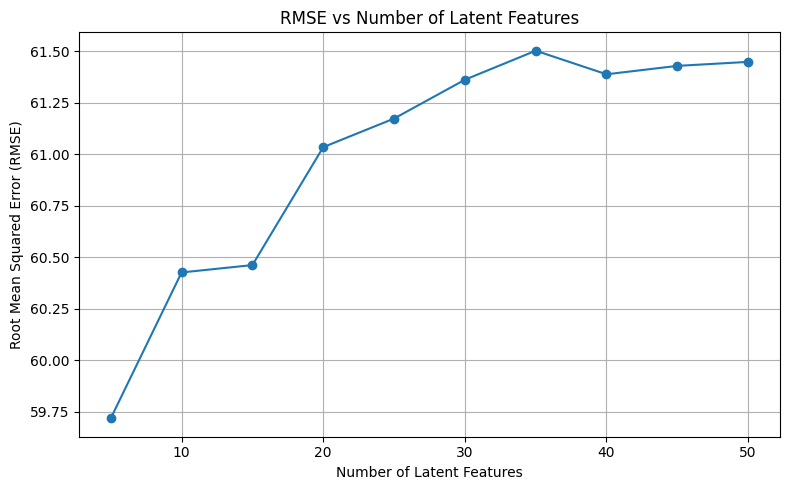

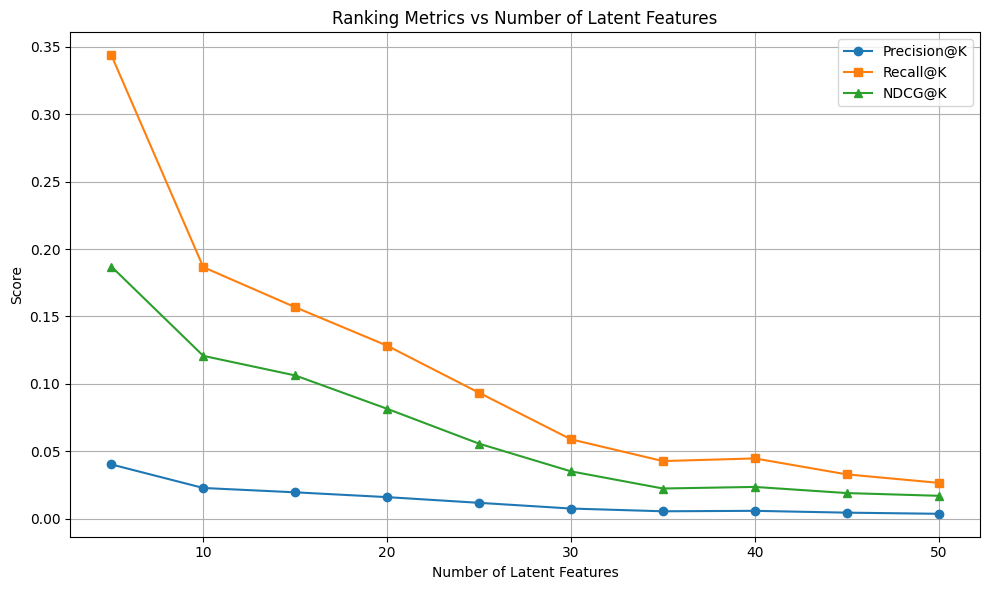

In [15]:
sparse_matrix = to_sparse_matrix(user_page_scroll_matrix)

# Create training and test splits
train_matrix, test_matrix = train_test_split_mask(user_page_scroll_matrix.values)

# Evaluate different latent feature sizes using ranking metrics and RMSE
latent_range = range(5, 55, 5)
results = compute_metrics_over_latent_features(
    train_matrix, test_matrix, latent_range, k=10
)

for entry in results:
    print(
        f"Latent Features: {entry['n_components']}, RMSE: {entry['rmse']:.4f}, "
        f"Precision@10: {entry['precision']:.4f}, Recall@10: {entry['recall']:.4f}, NDCG@10: {entry['ndcg']:.4f}"
    )

plot_rmse(results)
plot_ranking_metrics(results)

Okay, for whatever reason, our RSME and prediction metics all suffer the more latent features we add. There's definitely things to inspect w.r.t. our setup, but for now let's forge ahead and assume that the best model only have 5 latent features. 

In [ ]:
def recommend_from_final_model(interaction_df, n_components=5, top_n=10):
    """Train SVD on all interactions and generate top-N recommendations per user."""
    matrix = interaction_df.values
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    user_features = svd.fit_transform(matrix)
    item_features = svd.components_
    predictions = np.dot(user_features, item_features)

    recommendations = {}
    for user_idx, user_id in enumerate(interaction_df.index):
        user_pred = predictions[user_idx]
        seen_items = np.where(matrix[user_idx] > 0)[0]
        user_pred[seen_items] = -np.inf  # Mask seen items
        top_items = np.argsort(user_pred)[-top_n:][::-1]
        recommended_pages = [interaction_df.columns[i] for i in top_items]
        recommendations[user_id] = recommended_pages

    return recommendations

In [ ]:
final_recs = recommend_from_final_model(
    user_page_scroll_matrix, n_components=5, top_n=10
)

# Print top recommendations for the first 5 users
for user_id, pages in list(final_recs.items())[:5]:
    print(f"Top recommendations for user {user_id}:")
    for page in pages:
        print(f" - {page}")

Top recommendations for user 1000102388.1739115104:
 - https://dallasfreepress.com/west-dallas/disd-resource-center-west/
 - https://dallasfreepress.com/south-dallas/where-do-you-go-on-saturday-morning-how-a-zoning-plan-could-make-way-for-new-businesses-in-south-dallas/
 - https://dallasfreepress.com/west-dallas-events/
 - https://dallasfreepress.com/south-dallas/
 - https://dallasfreepress.com/events/community-meeting-bonton-master-plan/
 - https://dallasfreepress.com/author/brenda-hernandez/
 - https://dallasfreepress.com/dallas-news/public-meeting-briefs/gentrification-concerns-halt-duplex-in-owenwood/
 - https://dallasfreepress.com/west-dallas/code-change-could-limit-efforts-to-battle-polluting-industries-and-dallas-officials-want-more-info/
 - https://dallasfreepress.com/dallas-news/public-meeting-briefs/dallas-could-move-community-care-funds-to-hire-more-police/
 - https://dallasfreepress.com/west-dallas/
Top recommendations for user 1000496648.1739037737:
 - https://dallasfreepr